# Módulos utilizados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib

from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# Preparación del dataset

In [5]:
cd /content/drive/MyDrive/CURSOS/EOI/Python-Developer-EOI/module3/examen

/content/drive/MyDrive/CURSOS/EOI/Python-Developer-EOI/module3/examen


In [ ]:
# Lectura del dataset
filename = 'AB_NYC_2019.csv'
data = pd.read_csv(filename)

In [ ]:
# Primeras filas
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
# Busco valores nulos que puedan perjudicar mi análisis para eliminarlos
# posteriormente en caso de que no sean necesarios
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Exploratory Data Analysis

Text(0.5, 1.0, 'room_type VS price')

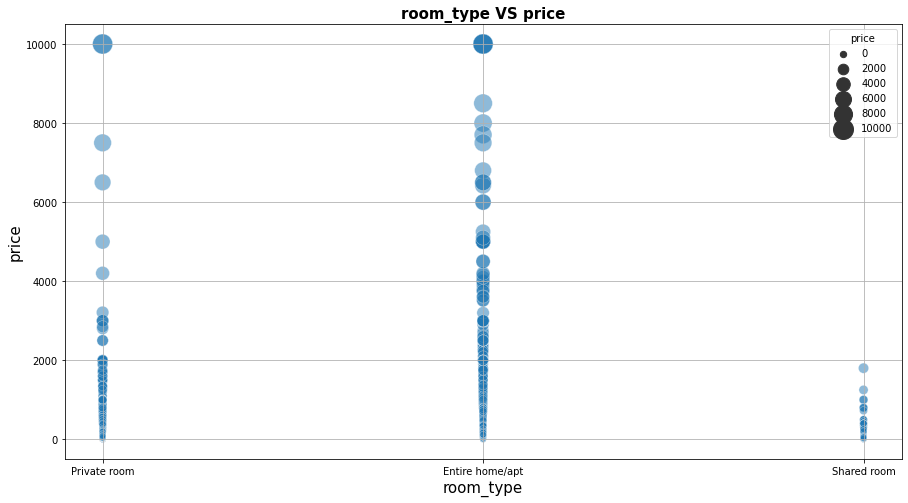

In [ ]:
# Relación entre el precio y el tipo de habitación
# El precio de la habitación compartida siempre es inferior a 2000 dólares
# Las habitaciones privadas y las propiedades completas tienen los precios más altos

plt.figure(figsize=(15, 8))
sns.scatterplot(x='room_type', y='price', data=data, sizes=(40, 400), alpha=.5, size="price")

plt.xlabel("room_type", size=15)
plt.ylabel("price", size=15)
plt.grid(b=True)
plt.title("room_type VS price", size=15, weight='bold')

Text(0.5, 1.0, 'neighbourhood_group VS price')

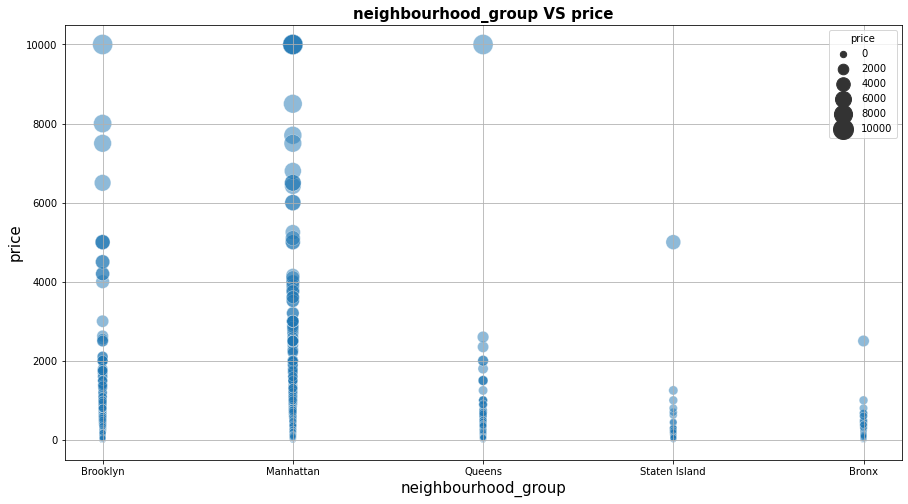

In [ ]:
# Las áreas con mayor concetración de propiedas son Brooklyn y Manhattan, así
# como aquellas con mayor dispersión en los precios

plt.figure(figsize=(15, 8))
sns.scatterplot(x='neighbourhood_group', y='price', data=data, sizes=(40, 400), alpha=.5, size="price")

plt.xlabel("neighbourhood_group", size=15)
plt.ylabel("price", size=15)
plt.grid(b=True)
plt.title("neighbourhood_group VS price", size=15, weight='bold')

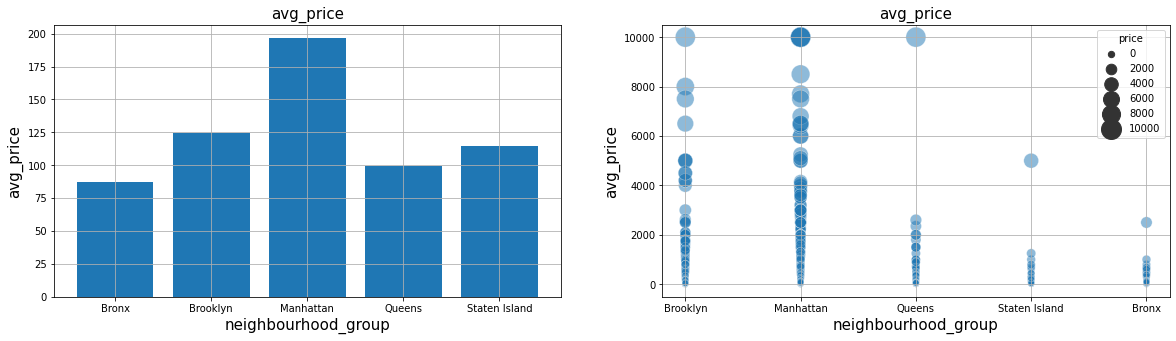

In [ ]:
# En estas gráficas, se puede ver que el precio medio no es un buen indicador en
# este análisis, ya que hay una desviación muy fuerte  en los precios

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.bar(sorted(data.neighbourhood_group.unique()), data.groupby('neighbourhood_group').mean()['price'])
ax1.set_xlabel("neighbourhood_group", size=15)
ax1.set_ylabel("avg_price", size=15)
ax1.set_title("avg_price", size=15)
ax1.grid(b=True)

sns.scatterplot(x='neighbourhood_group', y='price', data=data, sizes=(40, 400), alpha=.5, size="price", ax=ax2)
ax2.set_xlabel("neighbourhood_group", size=15)
ax2.set_ylabel("avg_price", size=15)
ax2.set_title("avg_price", size=15)
ax2.grid(b=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


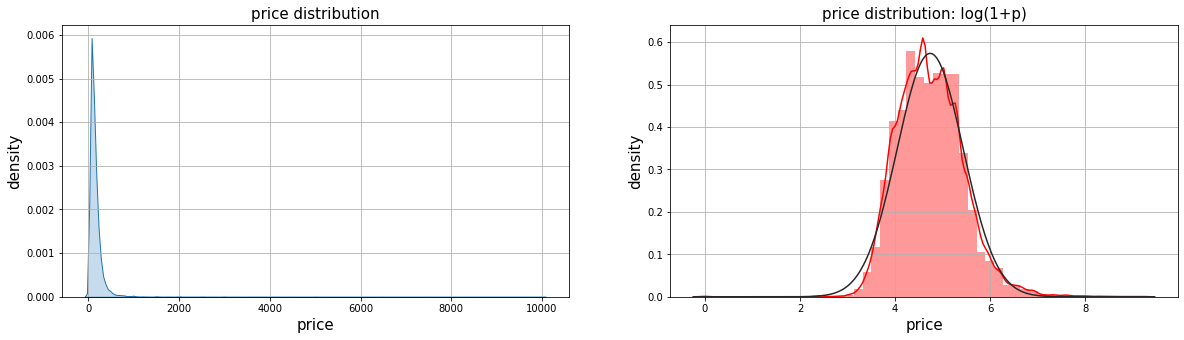

In [ ]:
# Añado un campo con la transformación logarítimica, de forma que el análisis de los datos y sus interpretación sea más sencilla
data['price_log'] = np.log(data.price + 1)

# En la gráfica azul, pueve verse que hay una distribución de precios muy sesgada (concretamente, sesgo positivo)
# En la gráfica roja, los precios siguen una distribución log(1+p) (transformación logarítmica)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

sns.kdeplot(data.price, shade=True, ax=ax1)
ax1.set_xlabel("price", size=15)
ax1.set_ylabel("density", size=15)
ax1.set_title("price distribution", size=15)
ax1.grid(b=True)

sns.distplot(data.price_log, fit=norm, ax=ax2, color='r')
ax2.set_xlabel("price", size=15)
ax2.set_ylabel("density", size=15)
ax2.set_title("price distribution: log(1+p)", size=15)
ax2.grid(b=True)

((array([-4.18631264, -3.98032736, -3.86801681, ...,  3.86801681,
          3.98032736,  4.18631264]),
  array([0.        , 0.        , 0.        , ..., 9.21044037, 9.21044037,
         9.21044037])),
 (0.6871218845318134, 4.736884710386776, 0.9881016272577388))

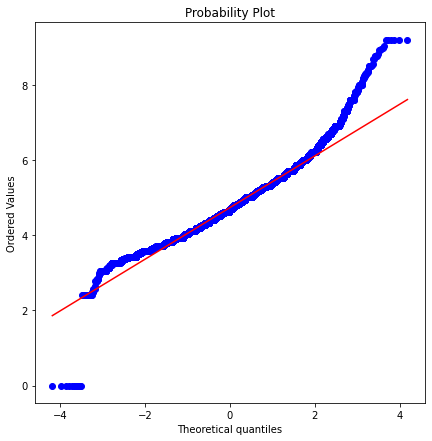

In [ ]:
# Prueba de normalidad para determinar si el conjunto de datos está bien modelado por una distribución normal
plt.figure(figsize=(7, 7))
stats.probplot(data.price_log, plot=plt)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


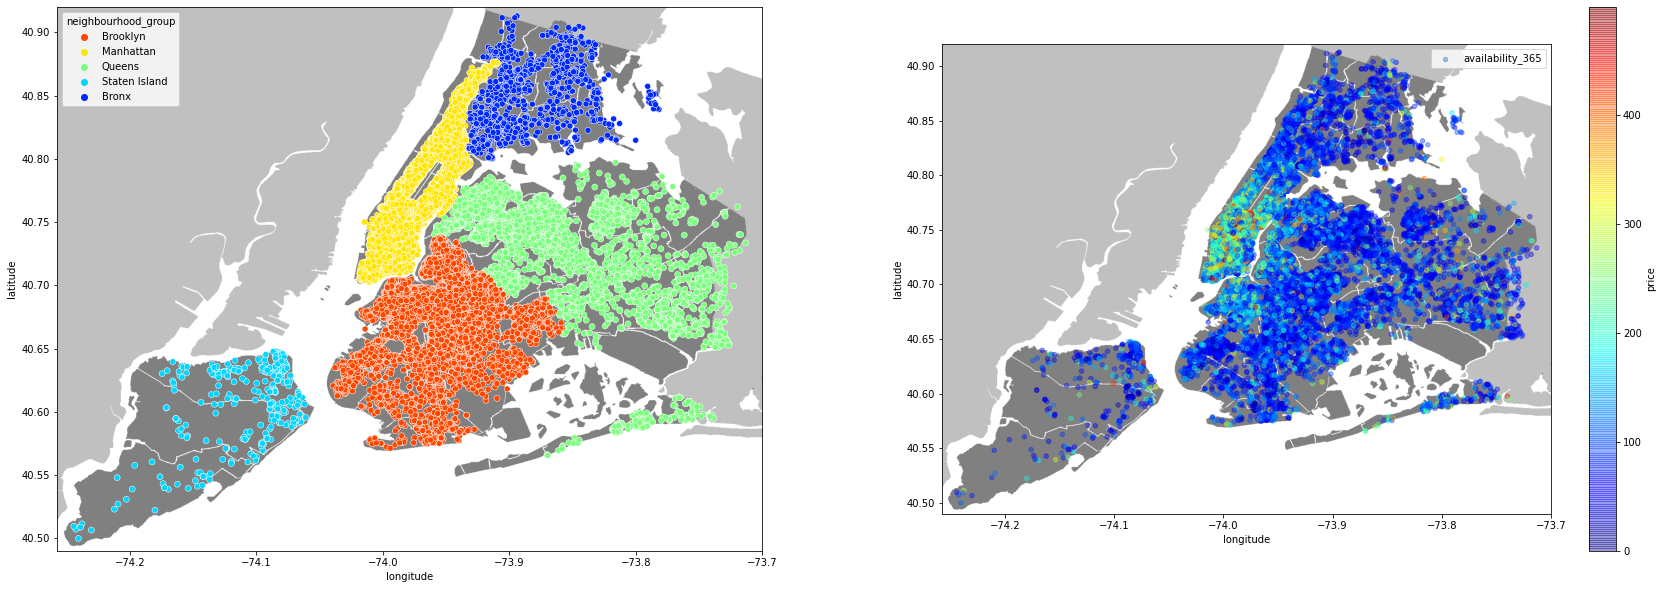

In [ ]:
# Distribución espacial de los alojamientos
f, axes = plt.subplots(1, 2, figsize=(30,10))

# plt.figure(figsize=(10,8))

# Loading the png NYC image found on Google and saving to my local folder along with the project
i= urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img = plt.imread(i)

axes[0].imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49, 40.92])
sns.scatterplot(data.longitude, data.latitude, hue=data.neighbourhood_group, palette='jet_r', ax=axes[0], zorder=1)

axes[1].imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49, 40.92])
data[data.price < 500].plot(kind='scatter', x='longitude', y='latitude',
                            label='availability_365', c='price',
                            ax=axes[1],
                            cmap=plt.get_cmap('jet'),
                            colorbar=True,
                            alpha=0.4,
                            zorder=1)

plt.legend()
plt.show()

# Model Building

In [ ]:
# Preparo los datos para elaborar el modelo y elimino datos no necesarios
# 'dmodel' (data model) es un nuevo DataFrame con los datos necesarios para la elaboración del modelo
# De entre los datos que se eliminan, destaco que elimino la columna 'price', ya que usaré de aquí en adelante 'price_log', que es su distribución logarítmica
dmodel = data.drop(columns=['name', 'id', 'host_id', 'host_name', 'last_review', 'price'])
dmodel.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
price_log                             0
dtype: int64

In [ ]:
# El número de reviews tiene algunos datos faltantes, los cuales voy a reemplazar por la media, ya que estos datos son más simétricos (no presentan una alta desviación)
# De esta forma, ya no tengo datos faltantes (ni null ni NaN)
mean = dmodel['reviews_per_month'].mean()
dmodel['reviews_per_month'].fillna(mean, inplace=True)
dmodel.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
price_log                         0
dtype: int64

Text(0.5, 1.0, 'Spearman method')

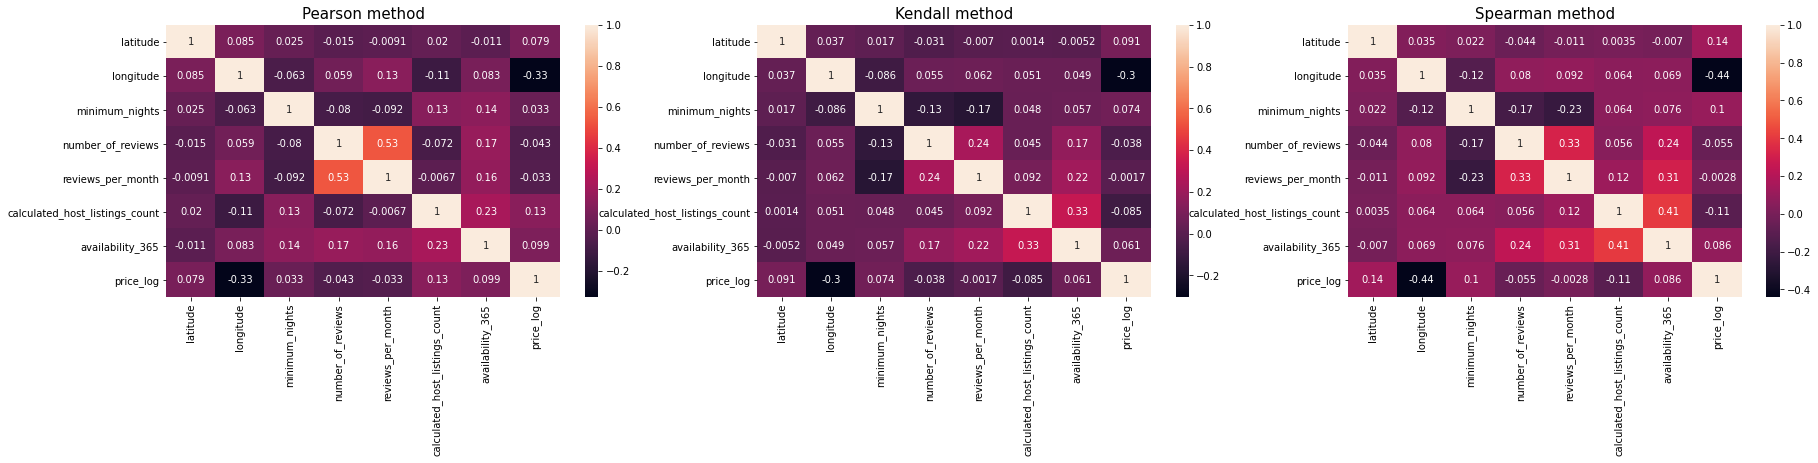

In [ ]:
# Matrices de correlación (con distintos métodos)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

# Correlación (método de Pearson)
corr1 = dmodel.corr(method='pearson')
sns.heatmap(corr1, annot=True, ax=ax1)
ax1.set_title("Pearson method", size=15)

# Correlación (método de Kendall)
corr2 = dmodel.corr(method='kendall')
sns.heatmap(corr2, annot=True, ax=ax2)
ax2.set_title("Kendall method", size=15)

# Correlación (método de Spearman)
corr3 = dmodel.corr(method='spearman')
sns.heatmap(corr3, annot=True, ax=ax3)
ax3.set_title("Spearman method", size=15)

# De acuerdo con las matrices de correlación, no hay fuerte relación entre el precios y otras variables, por lo que no es necesario eliminar más datos

In [ ]:
# La multicolinealidad ayuda a medir la relación entre las variables explicativas en la regresión múltiple
# Si se da la multicolinealidad, estas variables de entrada altamente relacionadas deben ser eliminadas (no incluidas en el modelo)
# Dicha multicolinealidad debe ser controlada con los autovectores
# Voy a tomar la matriz de correlación obtenida con el método de Pearson

multicollinearity, V = np.linalg.eig(corr2)
multicollinearity

# Ninguno de los valores propios de la matriz de correlación es cercano a cero, por lo que no existe multicolinealidad en los datos

array([1.62323446, 1.32545299, 1.18263489, 1.02120012, 0.57642321,
       0.69351065, 0.74803324, 0.82951044])

In [ ]:
# Voy a reescalar los datos de forma que cada feature tenga media 0 y desviación estándar unidad
dmodel_x = dmodel.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'])
dmodel_y = dmodel.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'])

scaler = StandardScaler()
dmodel_x = scaler.fit_transform(dmodel_x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dmodel_x, dmodel_y, test_size=0.3, random_state=42)

# Linear Regression

In [ ]:
def linear_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_LR= LinearRegression()

    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_LR = GridSearchCV(estimator=model_LR,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_LR.fit(input_x, input_y)
    best_parameters_LR = grid_search_LR.best_params_  
    best_score_LR = grid_search_LR.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)


# linear_reg(nyc_model_x, nyc_model_y)

# Model Prediction

In [ ]:
lr = LinearRegression(copy_X= True, fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)

# Exportar a PDF

In [13]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!jupyter nbconvert --to pdf exam-module3-airbnb.ipynb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-generic-recommended is already the newest version (2017.20180305-1).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
[NbConvertApp] Converting notebook exam-module3-airbnb.ipynb to pdf
[NbConvertApp] Support files will be in exam-module3-airbnb_files/
[NbConvertApp] Making directory ./exam-module3-airbnb_files
[NbConvertApp] Making directory ./exam-module3-airbnb_files
[NbConvertApp] Making directory ./exam-module3-airbnb_files
[NbConvertApp] Making directory ./exam-module3-airbnb_files
[NbConvertApp] Making directory ./exam-module3-airbnb_files
[NbConvertApp] Making directory ./exam-module3-airbnb_files
[NbConvertApp] Making directory ./exam-module3-airbnb_files
[NbConvertApp] Writing 57458 bytes to ./notebook.tex
[NbConvertApp] Bu